# Applying classic CNN models: NN vs LeNet vs AlexNet

In this practice you will apply different Neural Networks models to solve a set of problems:
1. First, we start with lego bricks and try to classify them with using basic models
2. Next, we will apply same models for FashionMNIST dataset, it contains 60K samples of 10 classes
3. Then we will use higher-dimension pictures and will see whether thee techniques still works



## Part I: Lego bricks

As for beginning, lets follow the already known example - Lego bricks, brought by Linux Academy (its not exist anymore though :( ). And compare their model to some classic models that you will build: LeNet & AlexNet.


### Task 1.1 - Neural Network (MLP)

**Task: Use Lego bricks dataset and model to classify samples**


Original Notebook: [https://github.com/linuxacademy/content-aws-mls-c01/blob/master/MXNet-Basic-Classification/MXNet_Basic_Classification.ipynb](https://github.com/linuxacademy/content-aws-mls-c01/blob/master/MXNet-Basic-Classification/MXNet_Basic_Classification.ipynb)

In [1]:
import torch
from torch import nn
import torch.optim as optim

import pickle
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [3]:
# Open the files:
train_fh = open('./../data/lego-train.pickle', 'rb')
test_fh = open('./../data/lego-test.pickle', 'rb')

# Use pickle to load files into runtime objects:
train_data = pickle.load(train_fh)
test_data = pickle.load(test_fh)

# train_data -> [] of tuples: (ndarray, uint8 label) 

In [4]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

train_data_X = [img for (img, _) in train_data]
train_data_y = [lbl for (_, lbl) in train_data]

test_data_X = [img for (img, _) in test_data]
test_data_y = [lbl for (_, lbl) in test_data]

img_transforms = transforms.Compose([
#    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

def get_dataset(X, y):
    tensor_x = torch.Tensor(X) # transform to torch tensor
    tensor_x = img_transforms(tensor_x)
    tensor_y = torch.Tensor(y).long()

    dataset = TensorDataset(tensor_x,tensor_y) # create your datset
    return dataset

train_dataset = get_dataset(train_data_X, train_data_y)
test_dataset = get_dataset(test_data_X, test_data_y)


/var/folders/gg/bml4b3hs12gbbw_sdm078fw40000gn/T/ipykernel_35275/3339772338.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  tensor_x = torch.Tensor(X) # transform to torch tensor


In [5]:
# For humans:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick', '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles', '1x2 Grill']


Original shape is  torch.Size([48, 48, 1])


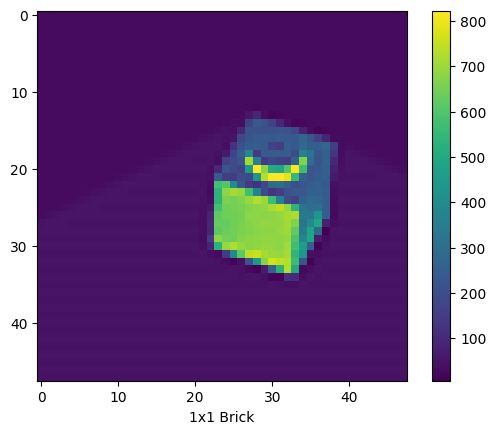

In [6]:
# the same, but with torch dataset
train_dataloader = DataLoader(train_dataset)

images_data, labels_data = next(iter(train_dataloader))
print('Original shape is ', images_data[0].shape)
plt.figure()
plt.imshow(images_data[0].numpy())
plt.colorbar()
plt.xlabel(class_names[labels_data[0]])
plt.show()

In [ ]:
# Define a neural network as per the original lab
def build_NN(input_size=48):
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    net = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(input_size * input_size, 128),
        torch.nn.Sigmoid(),
        torch.nn.Linear(128, 64),
        torch.nn.Sigmoid(),
        torch.nn.Linear(64, 10)
    )
    
    net.apply(init_weights)
    
    return net

In [8]:
# lets use some fancy visualization of progress - https://github.com/tqdm/tqdm

In [ ]:
# define a train function, model-agnostic, which will be used for further training
def train(net, train_loader, device, num_epochs, learning_rate, needs_permute=True):
    
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                if needs_permute:
                    inputs = inputs.permute(0, 3, 1, 2).to(device)
                else:
                    inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                outputs = net(inputs)
                loss = loss_function(outputs, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total
                
                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            acc = correct/total 
            acc_history.append(acc)

        pbar.close()

    return acc_history

In [10]:
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

In [11]:
net = build_NN()
print(net)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2304, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=64, out_features=10, bias=True)
)


In [12]:
# prepare training
BATCH_SIZE = 32
EPOCHS = 200
LR = 0.001

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE)

hist = train(net, train_dataloader, device, EPOCHS, LR)

Epoch: 199, Batch: 14, Loss: 11.50, Acc: 1.00: 100%|██████████| 3000/3000 [00:07<00:00, 392.23it/s]


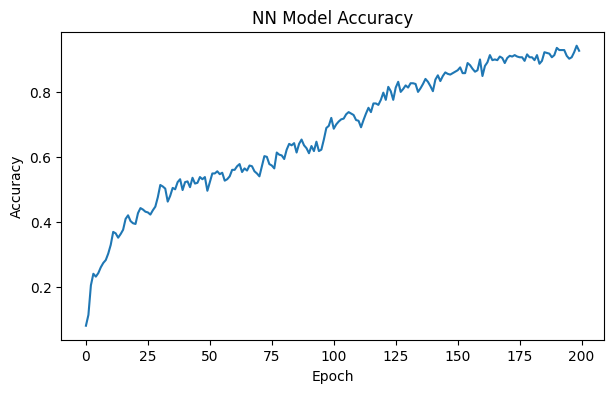

In [13]:
print_history(hist, "NN Model Accuracy")

#### Hyper-params tuning
https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html
https://stackoverflow.com/questions/44260217/hyperparameter-optimization-for-pytorch-model


In [14]:
import ray
from ray import tune
import pickle
import os
from torch.utils.data import TensorDataset, DataLoader

def hyper_opt_train_nn(config):
    import torch
    import torch.optim as optim
    from torch.utils.data import TensorDataset, DataLoader
    import torchvision.transforms as transforms
    from tqdm import tqdm
    
    # Определяем device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Используем абсолютные пути к данным
    base_path = '/Users/mansurzainullin/MyCode/5-sem-labs-for-big-data/data'
    train_fh = open(os.path.join(base_path, 'lego-train.pickle'), 'rb')
    test_fh = open(os.path.join(base_path, 'lego-test.pickle'), 'rb')
    train_data = pickle.load(train_fh)
    test_data = pickle.load(test_fh)
    train_fh.close()
    test_fh.close()
    
    # Подготавливаем датасеты
    train_data_X = [img for (img, _) in train_data]
    train_data_y = [lbl for (_, lbl) in train_data]
    test_data_X = [img for (img, _) in test_data]
    test_data_y = [lbl for (_, lbl) in test_data]
    
    img_transforms = transforms.Compose([
        transforms.Normalize(0.13, 0.31)])
    
    def get_dataset(X, y):
        tensor_x = torch.Tensor(X)
        tensor_x = img_transforms(tensor_x)
        tensor_y = torch.Tensor(y).long()
        dataset = TensorDataset(tensor_x, tensor_y)
        return dataset
    
    train_dataset = get_dataset(train_data_X, train_data_y)
    test_dataset = get_dataset(test_data_X, test_data_y)
    
    # Определяем build_NN
    def build_NN():
        def init_weights(m):
            if type(m) == torch.nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
        
        net = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(48*48, 128),
            torch.nn.Sigmoid(),
            torch.nn.Linear(128, 64),
            torch.nn.Sigmoid(),
            torch.nn.Linear(64, 10)
        )
        net.apply(init_weights)
        return net
    
    # Определяем функцию train
    def train(net, train_loader, device, num_epochs, learning_rate):
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        loss_function = torch.nn.CrossEntropyLoss()
        
        for epoch in range(num_epochs):
            for batch_num, (inputs, labels) in enumerate(train_loader):
                inputs = inputs.permute(0, 3, 1, 2).to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
    
    # Определяем функцию evaluate_acc
    def evaluate_acc(net, test_loader, device):
        total = 0
        correct = 0
        
        for batch_num, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.permute(0, 3, 1, 2).to(device)
            labels = labels.to(device)
            
            outputs = net(inputs)        
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        acc = correct/total
        return acc
    
    # Основная логика
    net = build_NN()
    
    BATCH_SIZE = config["batch_size"]
    EPOCHS = config["epochs"]
    LR = config["lr"]

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
    train(net, train_dataloader, device, EPOCHS, LR)
    
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    acc = evaluate_acc(net, test_dataloader, device)
    
    tune.report({"mean_accuracy": acc})


In [ ]:
from ray.tune import CLIReporter

ray.init(runtime_env={"env_vars": {"RAY_AIR_NEW_OUTPUT": "0"}}, ignore_reinit_error=True)

config = {
    "lr": tune.grid_search([0.001, 0.005, 0.01, 0.1]),
    "batch_size": tune.choice([8, 16, 32, 64]),
    "epochs": tune.grid_search([10, 50, 100, 200]),
}

reporter = CLIReporter(
        metric_columns=["mean_accuracy"])

analysis = tune.run(
    hyper_opt_train_nn, 
    config=config,
    progress_reporter=reporter,
    metric="mean_accuracy",
    mode="max")

print("Best config: ", analysis.get_best_config(metric="mean_accuracy", mode="max"))

# Get a dataframe for analyzing trial results.
df = analysis.dataframe()



### Task 1.2 - CNNs (LeNet + AlexNet)

Task: build classic CNN models (LeNet & AlexNet) and apply them for classification

LeNet is a classic neural network, that we can use to validate CNN approach on top of same Lego bricks dataset.
Compare and discuss what are the differences of LeNet & AlexNet architectures.

<br/>
<div>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/1920px-Comparison_image_neural_networks.svg.png" width="800"/>
</div>

In [ ]:
def build_lenet(input_size=48):
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        if type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    
    size_after_first_pool = input_size // 2
    size_after_second_conv = size_after_first_pool - 4
    size_after_second_pool = size_after_second_conv // 2
    flattened_size = size_after_second_pool * size_after_second_pool * 16
        
    net = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), padding=(2,2)),
        torch.nn.ReLU(),
        
        torch.nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5)),
        torch.nn.ReLU(),

        torch.nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

        torch.nn.Flatten(),
        
        torch.nn.Linear(flattened_size, 120),
        torch.nn.ReLU(),
        torch.nn.Linear(120, 84),
        torch.nn.Sigmoid(),
        torch.nn.Linear(84, 10)
    )
  
    net.apply(init_weights)
    return net

In [ ]:
lenet = build_lenet()
print(lenet)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): ReLU()
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1600, out_features=120, bias=True)
  (9): ReLU()
  (10): Linear(in_features=120, out_features=84, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
hist_lenet = train(lenet, train_dataloader, device, EPOCHS, LR)

Epoch: 199, Batch: 14, Loss: 1.87, Acc: 1.00: 100%|██████████| 3000/3000 [00:45<00:00, 66.36it/s]


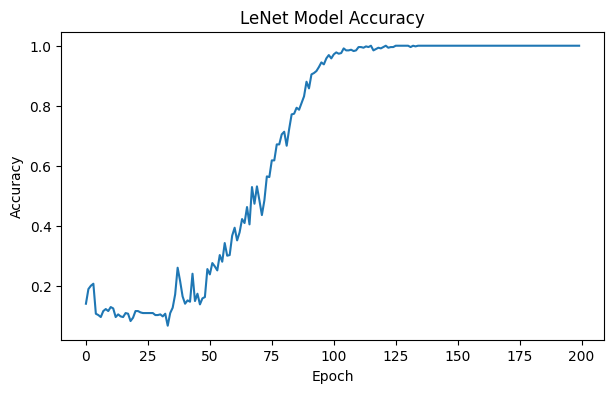

In [ ]:
print_history(hist_lenet, "LeNet Model Accuracy")

### Task 1.3 - Evaluate results

Task: Compare NN with given architectures. Discuss, why results are different

In [ ]:
def evaluate_acc(net, test_loader, device=device, needs_permute=True):
    total = 0
    correct = 0
    
    for batch_num, (inputs, labels) in enumerate(test_loader):
        if needs_permute:
            inputs = inputs.permute(0, 3, 1, 2).to(device)
        else:
            inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net(inputs)        
        _, predicted = outputs.max(1)
        
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    acc = correct/total
    return acc

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [ ]:
net_acc = evaluate_acc(net, test_dataloader, device)
lenet_acc = evaluate_acc(lenet, test_dataloader, device)

print('Test Accuracy (NN): {:.2%}'.format(net_acc))
print('Test Accuracy (LeNet): {:.2%}'.format(lenet_acc))

Test Accuracy (NN): 84.67%
Test Accuracy (LeNet): 100.00%


In [ ]:
import itertools

def show_random(net, dataloader):
    train_image_no = 109

    def get_prediction(net, input):
        input = input.permute(2, 0, 1).to(device)
        outputs = net(input)        
        _, predicted = outputs.max(1)
        return predicted


    images_data, original_label = next(iter(dataloader))
    images_data = images_data[0]
    original_label = original_label[0]
    
    predicted_label = get_prediction(net, images_data)
    print('original_label ', original_label) 
    print('predicted_label ', predicted_label)
    if original_label == predicted_label[0]: 
        c = 'green' 
    else:
        c = 'red'
    
    plt.figure()
    plt.imshow(images_data.numpy())
    plt.colorbar()

    plt.xlabel(class_names[predicted_label], color = c)
    plt.show()


original_label  tensor(4)
predicted_label  tensor([4])


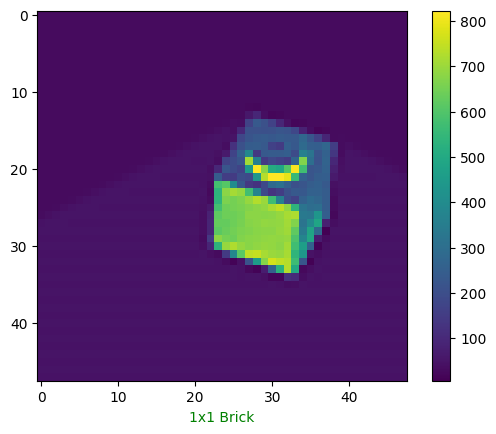

In [ ]:
#nn
show_random(net, test_dataloader)

## Part II: Fashion MNIST

Working with small dataset might not be a representable to show CNN benefits.

Lets switch to another dataset - Fashion MNIST. Original Repository - [https://github.com/zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)

<br/>
<div>
    <img src="https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png" width="400"/>
</div>
<br/>

To load dataset though the framework, one can use: [https://mxnet.apache.org/versions/1.6/api/python/docs/api/gluon/data/vision/datasets/index.html#mxnet.gluon.data.vision.datasets.FashionMNIST](https://mxnet.apache.org/versions/1.6/api/python/docs/api/gluon/data/vision/datasets/index.html#mxnet.gluon.data.vision.datasets.FashionMNIST)


In [ ]:
# Load the training data
fashion_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.13,), (0.31,))])

fashion_train_data = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=fashion_transformer)
fashion_test_data = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=fashion_transformer)

In [ ]:
fashion_batch_size = 512
fashion_epochs = 20

fashion_train_loader = DataLoader(fashion_train_data, batch_size=fashion_batch_size, shuffle=False)
fashion_test_loader = DataLoader(fashion_test_data, batch_size=fashion_batch_size, shuffle=False)

In [ ]:
fashion_net = build_NN(input_size=28)

In [ ]:
fashion_hist_nn = train(fashion_net, fashion_train_loader, device, fashion_epochs, LR, needs_permute=False)

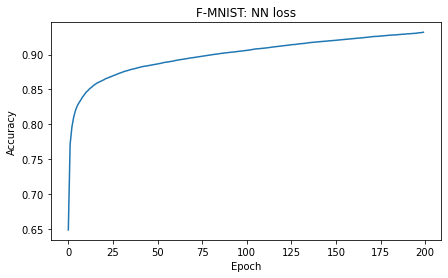

In [ ]:
print_history(fashion_hist_nn, "F-MNIST: NN loss")

In [ ]:
fashion_lenet = build_lenet(input_size=28)

In [ ]:
fashion_hist_lenet = train(fashion_lenet, fashion_train_loader, device, fashion_epochs, LR, needs_permute=False)

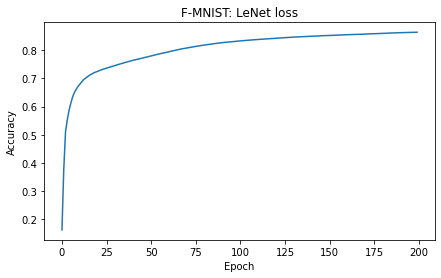

In [ ]:
print_history(fashion_hist_lenet, "F-MNIST: LeNet loss")

In [ ]:
fashion_net_acc = evaluate_acc(fashion_net, fashion_test_loader, needs_permute=False)
fashion_lenet_acc = evaluate_acc(fashion_lenet, fashion_test_loader, needs_permute=False)

print('Validation Fashion NN: {:.4f}'.format(fashion_net_acc))
print('Validation Fashion LeNet: {:.4f}'.format(fashion_lenet_acc))

In [ ]:
fashion_classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
def build_alexnet():
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        if type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    
    net = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=1, out_channels=96, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        
        torch.nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        
        torch.nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        
        torch.nn.Flatten(),
        torch.nn.Linear(256 * 3 * 3, 4096),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(4096, 4096),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(4096, 10)
    )
    
    net.apply(init_weights)
    return net

In [ ]:
fashion_alexnet = build_alexnet()
print(fashion_alexnet)

fashion_hist_alexnet = train(fashion_alexnet, fashion_train_loader, device, 25, LR, needs_permute=False)